# Installation and import libraries that will be used in the tutorial

In [20]:
# Install the developer's version on bash

# python -m pip install .
# If no priviledge 
# sudo -H python -m pip install .

from qshap import explainer
import sklearn.ensemble
import numpy as np
import time as time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost

from sklearn.datasets import make_regression

# Make a example
Let's start with a toy example with 1000 samples and 1000 features


In [21]:
np.random.seed(0)
x, y, coefficients = make_regression(n_samples=1000, n_features=1000, coef=True, random_state=0)

# Calculate Shapley R squared 

## Scikit learn decision tree example
The initial run after import will be slower since numba takes time to compile

### Fit a tree

In [22]:
# Let's start with a toy example with 1000 samples and 1000 features
np.random.seed(0)
x, y, coefficients = make_regression(n_samples=1000, n_features=1000, coef=True, random_state=0)

# model fitting
# scikit learn decision tree example, the initial run after import will be slower since numba is comiling
max_depth = 2
tree_regressor = DecisionTreeRegressor(max_depth=max_depth)
tree_fit = tree_regressor.fit(x, y)

### Calculate Shapley R squared

In [23]:
explainer_rsq = explainer(tree_regressor)
rsq_res = explainer.rsq(explainer_rsq, x, y)

### Check with model R squared

In [24]:
# Let's check the model R^2
ypred = tree_regressor.predict(x)
sst = np.sum((y - np.mean(y)) ** 2)
sse = np.sum((y - ypred) ** 2)
model_rsq = 1 - sse/sst

print("Shapley R^2 sum is: " + str(np.sum(rsq_res)))
print("Model R^2 is: " + str(model_rsq) + "\n")

Shapley R^2 sum is: 0.2759939277003993
Model R^2 is: 0.2759939277003993



 ## Scikit learn GBDT example. The Usage is exactly the same.

### Fit a tree

In [25]:
max_depth = 2
n_estimators = 50
tree_regressor = xgboost.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth)
tree_regressor.fit(x, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Calculate Shapley R squared

In [26]:
explainer_rsq = explainer(tree_regressor)
rsq_res = explainer.rsq(explainer_rsq, x, y)

 ## XGBOOST example. The Usage is exactly the same.

### Fit a tree

In [27]:
max_depth = 2
n_estimators = 50
tree_regressor = xgboost.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth)
tree_regressor.fit(x, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### Calculate Shapley R squared

In [28]:
explainer_rsq = explainer(tree_regressor)
rsq_res = explainer.rsq(explainer_rsq, x, y)

#  Extract loss for each sample

## Simply output both R squared and loss

In [29]:
rsq_res2 = explainer.rsq(explainer_rsq, x, y, loss_out=True)
rsq_res2.rsq
rsq_res2.loss

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

##  You can also extract loss only

In [30]:
loss_res = explainer.loss(explainer_rsq, x, y)

## Loss for a specific example
Interstingly, you can calculate loss decomposition for arbitrarily sample (which doesn't make sense for R^2)
This will be particular fast if you only want to several samples among a large dataset. All you have to do is add the original mean of y.

In [31]:
loss_sample1 = explainer.loss(explainer_rsq, x[0:1, :], y[0], y_mean_ori=np.mean(y))
loss_multiple = explainer.loss(explainer_rsq, x[0:99], y[0:99], y_mean_ori=np.mean(y))

# Visualization 

## Import module

In [36]:
from qshap import vis_rsq, vis_loss

## Quick plot

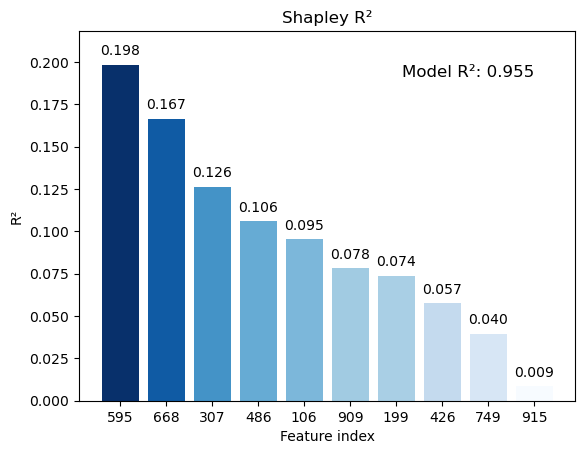

In [37]:
# default
vis_rsq(rsq_res)

## Change color

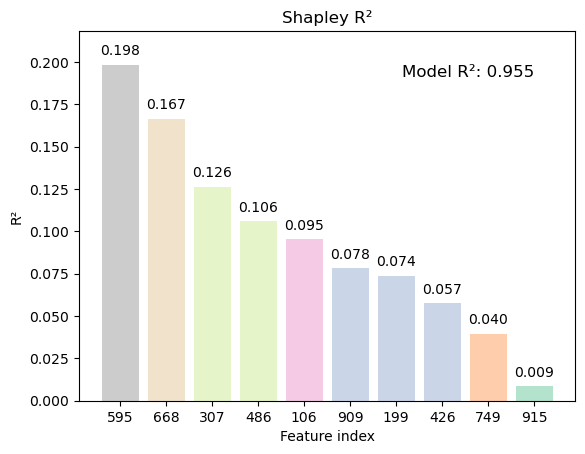

In [38]:
# change color 
vis_rsq(rsq_res, color_map_name="Pastel2")

## More
Give a horizontal plot, hide model rsq, change the number of features to show, and you can always save it

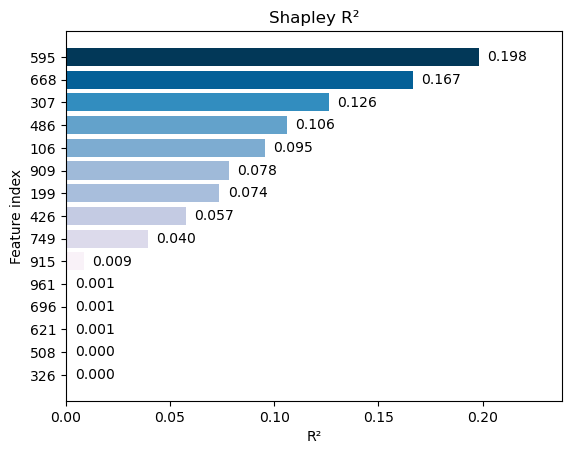

In [39]:
vis_rsq(rsq_res, color_map_name="PuBu", horizontal=True, model_rsq=False, max_feature=15, save_name="rsq_eg")

## Visualize individual loss

Output()

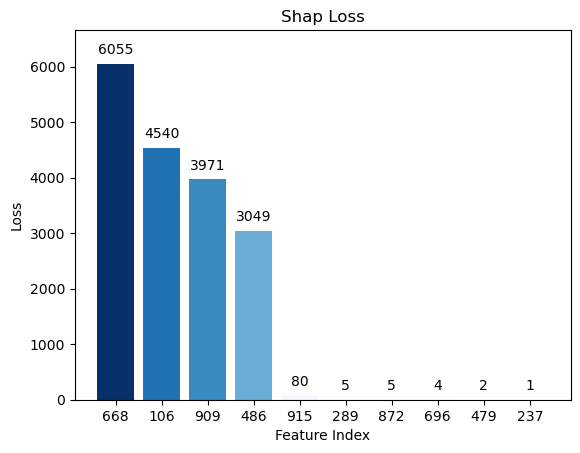

In [40]:
# Vidualize individual loss
# The interactive effect works with jupyter notebook
vis_loss(loss_res)

# Find a lovely plot for one sample and save it, say for the 10-th sample
vis_loss(loss_res, save_ind=10)